In [105]:
import numpy as np
import functools
import math
from matplotlib import collections as mc
import xml.etree.ElementTree as ET
from collections import namedtuple
import csv
import pprint


In [106]:
# Load the XML file
tree = ET.parse('./data_72.xml')
root = tree.getroot()

# Extract information
dataset = root.find('./info/dataset').text
name = root.find('./info/name').text

Vertex = namedtuple("Vertex", ["id", "isWarehouse", "x", "y"])
Request = namedtuple("Request", ["id", "node_id", "quantity"])

In [107]:
car_type = None
for vehicle_profile in root.findall('./fleet/vehicle_profile'):
    departure_node = vehicle_profile.find('departure_node').text
    arrival_node = vehicle_profile.find('arrival_node').text
    capacity = vehicle_profile.find('capacity').text
    car_type = { 'departure_node': departure_node, 'arrival_node': arrival_node, 'capacity': capacity }


In [108]:

nodes = []
warehouse = None
for node in root.findall('./network/nodes/node'):
    node_id = node.attrib['id']
    node_type = node.attrib['type']
    cx = node.find('cx').text
    cy = node.find('cy').text

    if node_type == '0':
        warehouse = Vertex(node_id, True,  float(cx), float(cy))

    nodes.append((node_id, node_type, cx, cy))

assert warehouse is not None

vertices = {}
for node in nodes:
    if node[1] == '0':
        result = True
    else:
        result = False
    vertexid = int(node[0])
    vertices[vertexid] = (Vertex(vertexid, result,  float(node[2]), float(node[3])))


requests_list = []

for request in root.findall('./requests/request'):
    request_id = request.attrib['id']
    node = request.attrib['node']
    quantity = request.find('quantity').text
    requests_list.append({'Request ID': request_id, 'Node': node, 'Quantity': quantity})

requests_list

requests = {}
for request in requests_list:
    requests[request['Request ID']] = (Request(int(request['Request ID']), int(request['Node']), float(request['Quantity'])))

In [109]:
# Define the dictionaries
dictionaries = [requests, vertices]

# Print the first 5 elements of each dictionary
for dictionary in dictionaries:
    print("\n")
    print(*list(dictionary.items())[:5], sep="\n")




('1', Request(id=1, node_id=2, quantity=7063.0))
('2', Request(id=2, node_id=3, quantity=51.0))
('3', Request(id=3, node_id=4, quantity=23.0))
('4', Request(id=4, node_id=5, quantity=3074.0))
('5', Request(id=5, node_id=6, quantity=349.0))


(1, Vertex(id=1, isWarehouse=True, x=0.0, y=0.0))
(2, Vertex(id=2, isWarehouse=False, x=-12.0, y=-6.0))
(3, Vertex(id=3, isWarehouse=False, x=-15.0, y=-5.0))
(4, Vertex(id=4, isWarehouse=False, x=-1.0, y=-18.0))
(5, Vertex(id=5, isWarehouse=False, x=2.0, y=-21.0))


In [110]:
@functools.lru_cache(maxsize=None)
def distance_function(v1, v2):
    return math.sqrt(((v1.x - v2.x) * (v1.x - v2.x)) + ((v1.y - v2.y) * (v1.y - v2.y)))


def fitness_function(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:] + solution[0:1]):
        solution_distance += distance(x, y)
    
    return solution_distance

def initialize_pheromone(N):
    return 0.01 * np.ones(shape=(N,N))


def update_pheromone(pheromones_array, solutions, fitness_values, Q, rho):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fitness_value in zip(solutions, fitness_values):
        for x, y in zip(solution, solution[1:] + solution[0:1]):
            pheromone_update[x.id, y.id] += Q / fitness_value
    
    return (1 - rho) * pheromones_array + pheromone_update

def generate_solutions(vertices, requests, pheromones, distance_function, number_of_ants, car_capacity, alpha=1, beta=3):
    
    # Probability of selecting v2 right after v1
    def compute_prob(v1, req):
        v2 = vertices[int(req)]
        distance = distance_function(v1, v2)
        
        # obezlicka, uvidime jestli to pofacha
        if(distance == 0):
            return 1e-6
        inverse_distance = 1 / distance 
        tau = pheromones[v1.id, v2.id]
        ret = pow(tau, alpha) * pow(inverse_distance, beta)
        return ret if ret > 1e-6 else 1e-6
    
    for _ in range(number_of_ants):
        remaining_requests = list(requests)
        solution = [vertices[1]]  # Start from the warehouse
        capacity = car_capacity
        #print(capacity)
        while remaining_requests:
            probs = np.array([compute_prob(solution[-1], req) for req in remaining_requests])
            probs /= probs.sum()  # Normalize probabilities
            
            selected_index = np.random.choice(len(remaining_requests), p=probs)
            selected_request = remaining_requests[selected_index]
            request = requests[selected_request]
            new_request_capacity = request.quantity

            selected_vertex = vertices[int(selected_request)]

            # Check if adding the selected request exceeds the capacity
            if capacity - new_request_capacity < 0:
                # Revisit the warehouse if capacity is exhausted
                solution.append(vertices[1])
                capacity = car_capacity
                print("Going back to the warehouse")
            
            else:
                solution.append(selected_vertex)
                remaining_requests.remove(selected_request)
                capacity -= request.quantity  # Decrement capacity
            print(capacity)
        # Return to the warehouse after serving all requests
        solution.append(vertices[1])
        
        yield solution


def ant_solver(vertices, distance_function, number_of_ants=30, max_iterations=150, alpha=1, beta=3, Q=200, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float("inf")
    log_of_best_distances = list()
    
    print("Iteration\tMinimum value\tMean value\tMaximum value")
    
    for i in range(max_iterations):
        candidate_solutions = list(generate_solutions(vertices, requests, pheromones, distance_function, number_of_ants, float(car_type['capacity']), alpha=alpha, beta=beta))
        fitness_values = list(map(lambda x: fitness_function(vertices, distance_function, x), candidate_solutions))
        pheromones = update_pheromone(pheromones, candidate_solutions, fitness_values, Q=Q, rho=rho)
        
        for candidate_solution, fitness_value in zip(candidate_solutions, fitness_values):
            if fitness_value < best_fitness:
                best_fitness = fitness_value
                best_solution = candidate_solution
                
        log_of_best_distances.append(np.min(fitness_values))
        
        print(f"{i:8}:\t{np.min(fitness_values):5.8f}\t{np.mean(fitness_values):5.8f}\t{np.max(fitness_values):5.8f}")
    return best_solution, pheromones, log_of_best_distances
print("Request count: ", len(requests))
print("Vertex count: ", len(vertices))
best_solution, pheromones, log_of_best_distances = ant_solver(vertices, distance_function)


Request count:  71
Vertex count:  72
Iteration	Minimum value	Mean value	Maximum value
19765.0
18076.0
15182.0
14771.0
14742.0
14292.0
7143.0
6998.0
6952.0
5005.0
4826.0
4769.0
4718.0
4167.0
3639.0
807.0
756.0
Going back to the warehouse
30000.0
29867.0
27527.0
27509.0
26703.0
25682.0
25299.0
23049.0
19115.0
18933.0
18799.0
18331.0
17067.0
16313.0
14436.0
14418.0
14410.0
13849.0
10307.0
10295.0
9328.0
7962.0
7900.0
5448.0
5218.0
3686.0
2977.0
2176.0
1154.0
Going back to the warehouse
30000.0
28953.0
25879.0
22878.0
22847.0
22498.0
21363.0
20665.0
20659.0
19770.0
19747.0
19006.0
19002.0
17439.0
14389.0
13506.0
12291.0
10481.0
7927.0
Going back to the warehouse
30000.0
29883.0
29676.0
26011.0
25515.0
24001.0
16938.0
16934.0
Going back to the warehouse
30000.0
8389.0
27106.0
16871.0
15182.0
14799.0
12549.0
12404.0
5255.0
5209.0
1275.0
1093.0
959.0
Going back to the warehouse
30000.0
29589.0
29139.0
29110.0
28931.0
28880.0
28823.0
28272.0
28221.0
27523.0
5912.0
2838.0
1791.0
1760.0
1411.0
G

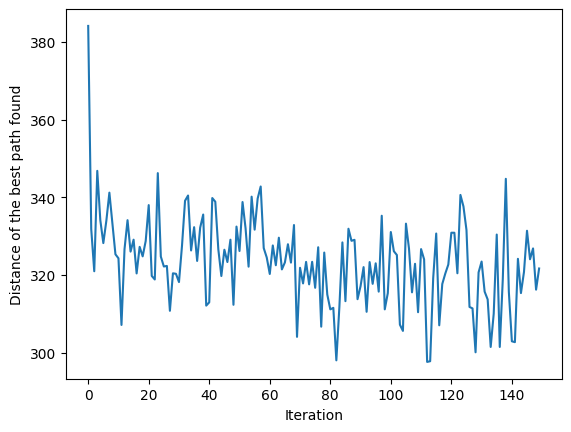

In [111]:
from matplotlib import pyplot as plt

plt.plot(log_of_best_distances)
plt.ylabel("Distance of the best path found")
plt.xlabel("Iteration")
plt.show()

Fitness:  297.5934483136174


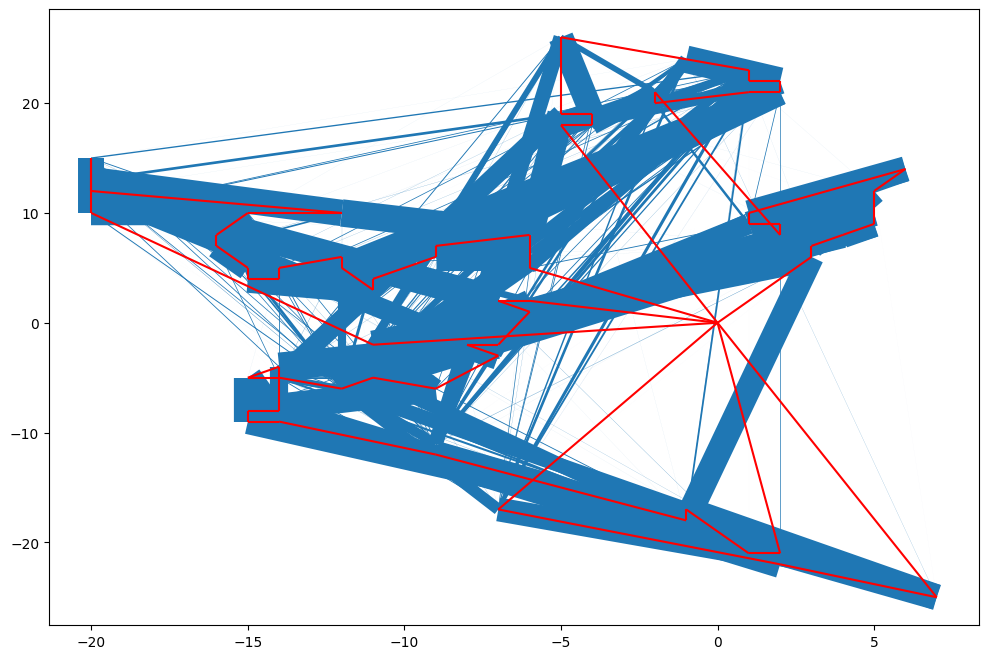

[Vertex(id=1, isWarehouse=True, x=0.0, y=0.0),
 Vertex(id=33, isWarehouse=False, x=-6.0, y=2.0),
 Vertex(id=35, isWarehouse=False, x=-7.0, y=2.0),
 Vertex(id=32, isWarehouse=False, x=-6.0, y=1.0),
 Vertex(id=37, isWarehouse=False, x=-7.0, y=-2.0),
 Vertex(id=34, isWarehouse=False, x=-8.0, y=-2.0),
 Vertex(id=36, isWarehouse=False, x=-7.0, y=-3.0),
 Vertex(id=19, isWarehouse=False, x=-9.0, y=-6.0),
 Vertex(id=12, isWarehouse=False, x=-11.0, y=-5.0),
 Vertex(id=2, isWarehouse=False, x=-12.0, y=-6.0),
 Vertex(id=16, isWarehouse=False, x=-14.0, y=-5.0),
 Vertex(id=3, isWarehouse=False, x=-15.0, y=-5.0),
 Vertex(id=20, isWarehouse=False, x=-14.0, y=-4.0),
 Vertex(id=14, isWarehouse=False, x=-14.0, y=-8.0),
 Vertex(id=18, isWarehouse=False, x=-15.0, y=-8.0),
 Vertex(id=17, isWarehouse=False, x=-15.0, y=-9.0),
 Vertex(id=13, isWarehouse=False, x=-14.0, y=-9.0),
 Vertex(id=7, isWarehouse=False, x=-9.0, y=-12.0),
 Vertex(id=4, isWarehouse=False, x=-1.0, y=-18.0),
 Vertex(id=6, isWarehouse=False

In [112]:
# Render pheromones (blue, line width corresponds to the pheromon value on the edge)
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(vertices[v1].x, vertices[v1].y), (vertices[v2].x, vertices[v2].y)])
        colors.append(pheromones[i, j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# Here, you can test the influence of the individual parameters on the generated candidate solution
# solution = list(generate_solutions(vertices, pheromones, distance_function, number_of_ants=1, alpha=3, beta=1))[0]

# Print solution's fitness
print("Fitness: ", fitness_function(vertices, distance_function, solution))

# Render the solution (red)
solution_lines = []
for i, j in zip(solution, solution[1:] + solution[0:1]):
    solution_lines.append([(i.x, i.y), (j.x, j.y)])

solutions_lc = mc.LineCollection(solution_lines, colors="red")

ax.add_collection(solutions_lc)

plt.show()

# Print towns in the order of the soultion
solution_vertices = [i for i in solution]
pprint.pprint(solution_vertices)